# PREVALÊNCIA

Prevalência = (Casos atuais da doença em um dado momento) / (Número de pessoas em risco de contrair a doença)

Nosso objetivo -> prevalência para cada 100 mil habitantes

Como fazer -> numero de casos acumulados por semana epidemiológica, dividir pela população e multiplicar por 100.000


### 1 - Preparar base de dados 
##### Coletar na base de dados disponibilizada as informações referentes ao indicador Epidemiológico do grupo

A) Abrir dataframe

B) Tratar dados faltantes ou em formato incorreto

C) Eliminar colunas desnecessárias

D) Guarda as datas do último dia de cada semana epidemiológica (usado mais tarde)

E) Mantém apenas dados dos estados (cidades não serão usadas)

F) pega o código e a população de cada estado

G) Separa os estados por regiões (ainda não agregados)

H) Adiciona uma coluna com os casos confirmados para cada semana ep.

I) Agrega os numeros de casos e a população de acordo com a região

J) Realiza o cálculo da prevalência de cada região em cada semana ep.

K) Calculo e inclusão da prevalência do total do Brasil


### A) Abrir dataframe

In [94]:
import pandas as pd

df_tabela_inteira = pd.read_csv("caso_full.csv")

pd.set_option("display.max_colwidth", 100000)
pd.set_option('display.max_rows', 200)

#df_tabela_inteira


### B) Tratar dados faltantes ou em formato incorreto

In [95]:
df_tabela_inteira.dropna(axis=0,subset=['city_ibge_code'],inplace=True) #retira linhas sem o código da cidade
df_tabela_inteira = df_tabela_inteira.astype({'city_ibge_code':int},copy=False) #transforma os códigos da cidade em inteiro
df_tabela_inteira = df_tabela_inteira.astype({'last_available_confirmed':int},copy=False)

#substitui os NaN de uma coluna por 0
df_tabela_inteira['last_available_confirmed_per_100k_inhabitants'] = df_tabela_inteira['last_available_confirmed_per_100k_inhabitants'].fillna(0)

#df_tabela_inteira.loc[df_tabela_inteira['date'] == "2020-03-12"]


### C) Eliminar colunas desnecessárias

In [96]:
#Remove colunas desnecessarias
#deixei de tirar 'last_available_confirmed_per_100k_inhabitants', 'estimated_population_2019'
df_tab_reduzida = df_tabela_inteira.drop(columns=['is_last', 'is_repeated', 'new_confirmed', 'new_deaths', 'last_available_death_rate', 'order_for_place'])


### D) Guarda as datas do último dia de cada semana epidemiológica (usado mais tarde)


In [97]:
#cria lista com a última data de cada semana epidemiológica (por algum motivo usa sao paulo como parametro. deve ser pq é a cidade que aparece desde o inicio)
ultimo_dia_semana = list(df_tab_reduzida[df_tab_reduzida['city']=='São Paulo'].groupby('epidemiological_week')['date'].agg(lambda x:x[x.last_valid_index()]).values)
#ultimo_dia_semana

### E) Mantém apenas dados dos estados (cidades não serão usadas)

In [98]:
#seleciona apenas os estados
tab_states = df_tab_reduzida[df_tab_reduzida['place_type']=='state']

#tab_states.head()

### F) pega o código e a população de cada estado

In [99]:
#pega o código e a população de cada estado (baseado na semana 31, quando já haviam muitos dados disponíveis)
df_states = tab_states[tab_states['epidemiological_week']==31].groupby('state')[['estimated_population_2019']].agg(lambda x:x[x.last_valid_index()]).copy()
#df_states

### G) Separa os estados por regiões (ainda não agregados)

In [100]:
import numpy as np
df_states["regiao"] = None

for index, row in df_states.iterrows():    
    
    if index in ['AC','AM','AP','TO','PA','RO','RR']:
        df_states.loc[index,'regiao']='norte'
        
    elif index in['AL','BA','CE','MA','PB','PE','PI','RN','SE']:
        df_states.loc[index,'regiao']='nordeste'
        
    elif index in['GO','MS','MT', 'DF']:
        df_states.loc[index,'regiao']='centro_oeste'
        
    elif index in['ES','MG','RJ','SP']:
        df_states.loc[index,'regiao']='sudeste'
        
    elif index in['PR','RS','SC']:
        df_states.loc[index,'regiao']='Sul'
    
    
#df_states.head()

### H) Adiciona uma coluna com os casos confirmados para cada semana ep.

In [101]:
#Confirmados para cada semana epidemiológica


for x in range(9,35):#9,35   
    
    semana_epidemiologica = tab_states[tab_states['epidemiological_week']==x]
    
    semana_epidemiologica_estado = semana_epidemiologica.groupby('state')['last_available_confirmed']
    
    prevalencia_semana = semana_epidemiologica_estado.agg(lambda x:x[x.last_valid_index().astype(int)])
    
    df_states['prevalencia_semana{}'.format(x)] = prevalencia_semana.astype(int)
      
    #-----------------------------------------------------------------------#    
    
df_states = df_states.fillna(0)
#df_states




### I) Agrega os numeros de casos e a população de acordo com a região

In [104]:
df_reg = df_states.groupby('regiao').sum()
df_reg

,estimated_population_2019,prevalencia_semana9,prevalencia_semana10,prevalencia_semana11,prevalencia_semana12,prevalencia_semana13,prevalencia_semana14,prevalencia_semana15,prevalencia_semana16,prevalencia_semana17,...,prevalencia_semana25,prevalencia_semana26,prevalencia_semana27,prevalencia_semana28,prevalencia_semana29,prevalencia_semana30,prevalencia_semana31,prevalencia_semana32,prevalencia_semana33,prevalencia_semana34
regiao,,,,,,,,,,,,,,,,,,,,,
Sul,29975984.0,0.0,0.0,15.0,169,521,1175,2073,2789,3556,...,50067,68627,94120,121543,152931,192044,235308,279471,321217,340637
centro_oeste,16297074.0,0.0,1.0,14.0,144,358,681,1022,1506,1989,...,62187,86286,114708,146402,171100,214521,256896,301467,345931,370082
nordeste,57071654.0,0.0,2.0,17.0,191,655,1680,4048,8804,16823,...,374714,452053,541509,623441,694499,784418,872782,949712,1019116,1052052
norte,18430980.0,0.0,0.0,2.0,32,189,537,1689,3463,7114,...,211496,254583,287964,320156,351162,385545,413676,445623,475421,491256
sudeste,88371433.0,2.0,16.0,88.0,596,2230,6308,12159,20613,30024,...,372873,457002,541740,632771,708263,822465,933330,1042124,1158423,1208618


### J) Realiza o cálculo da prevalência de cada região em cada semana ep.

In [105]:
###Alterando valores para a PREVALENCIA
##Apesar dos titulos das colunas estarem prevalencia, os valores iniciais se referiam 


#função que recebe uma série (linha do dataframe) e retorna uma lista com os novos valores de cada linha
def calc_prev(serie):
    
    lst_valores = []
    lst_valores.append(serie['estimated_population_2019'])
    
    for x in range(9,35):        
        
        #O cálculo da prevalência acontece aqui
        prev = (serie["prevalencia_semana{}".format(x)])/(serie['estimated_population_2019'])*100000
        lst_valores.append(prev)
    
    
    return lst_valores

#--------------------------------------------------------------------#

#'axis=1' manda series com as LINHAS para a função a ser aplicada
#'broadcast' mantém o nome das colunas
df_reg = df_reg.apply(calc_prev, axis=1, result_type='broadcast') 

df_reg = df_reg.drop(columns=['estimated_population_2019'])

df_reg

,prevalencia_semana9,prevalencia_semana10,prevalencia_semana11,prevalencia_semana12,prevalencia_semana13,prevalencia_semana14,prevalencia_semana15,prevalencia_semana16,prevalencia_semana17,prevalencia_semana18,...,prevalencia_semana25,prevalencia_semana26,prevalencia_semana27,prevalencia_semana28,prevalencia_semana29,prevalencia_semana30,prevalencia_semana31,prevalencia_semana32,prevalencia_semana33,prevalencia_semana34
regiao,,,,,,,,,,,,,,,,,,,,,
Sul,0.000000,0.000000,0.050040,0.563785,1.738058,3.919805,6.915536,9.304115,11.862830,18.421414,...,167.023708,228.939941,313.984689,405.467924,510.178415,640.659536,784.988409,932.316350,1071.581170,1136.366366
centro_oeste,0.000000,0.006136,0.085905,0.883594,2.196713,4.178664,6.271064,9.240923,12.204645,18.586158,...,381.583835,529.457006,703.856410,898.333038,1049.881715,1316.316045,1576.332046,1849.822858,2122.657110,2270.849356
nordeste,0.000000,0.003504,0.029787,0.334667,1.147680,2.943668,7.092838,15.426222,29.476980,50.960500,...,656.567619,792.079725,948.823036,1092.382919,1216.889561,1374.444133,1529.274060,1664.069522,1785.678053,1843.387963
norte,0.000000,0.000000,0.010851,0.173621,1.025447,2.913573,9.163919,18.789017,38.598056,70.251283,...,1147.502737,1381.277610,1562.391148,1737.053591,1905.281217,2091.831254,2244.460143,2417.793302,2579.466746,2665.381873
sudeste,0.002263,0.018105,0.099580,0.674426,2.523440,7.138053,13.758971,23.325411,33.974780,53.011475,...,421.938388,517.137704,613.026157,716.035690,801.461486,930.691030,1056.144467,1179.254386,1310.856869,1367.656899


### K) Calculo e inclusão da prevalência do total do Brasil

In [106]:
#---------total de casos confirmados----#

total_confirmed = tab_states[tab_states['date'].isin(ultimo_dia_semana)].groupby('epidemiological_week')['last_available_confirmed'].agg(sum)
 
#-------- População total---------#
semana_34 = tab_states[tab_states['date'].isin(ultimo_dia_semana)].loc[df_tabela_inteira['epidemiological_week'] == 34]
total_pop = semana_34['estimated_population_2019'].sum()


In [108]:


dict = {}
for x in range (26):
    dict['prevalencia_semana{}'.format(x+9)] = total_confirmed.values[x:x+1]
    
for x in range (26):
    dict['prevalencia_semana{}'.format(x+9)] = (dict['prevalencia_semana{}'.format(x+9)]/total_pop)*100000

df_br = pd.DataFrame(data=dict, index=['Brasil'])
#df_br

,prevalencia_semana9,prevalencia_semana10,prevalencia_semana11,prevalencia_semana12,prevalencia_semana13,prevalencia_semana14,prevalencia_semana15,prevalencia_semana16,prevalencia_semana17,prevalencia_semana18,...,prevalencia_semana25,prevalencia_semana26,prevalencia_semana27,prevalencia_semana28,prevalencia_semana29,prevalencia_semana30,prevalencia_semana31,prevalencia_semana32,prevalencia_semana33,prevalencia_semana34
Brasil,0.000952,0.009041,0.064717,0.53867,1.881063,4.939872,9.988716,17.689987,28.316352,46.362757,...,509.80331,627.441846,751.873717,877.629423,988.809626,1141.577835,1290.520629,1436.325622,1579.896941,1647.724184


In [111]:
#df_states.drop(index='TOTAL', inplace=True)
df_reg = pd.concat([df_reg, df_br])
#df_states

In [110]:
#Salva a tabela de prevalência por região
df_reg.to_csv('prevalencia_estado_semana.csv')

# 2 - Gráficos
##### Plotar Gráficos com a Evolução Temporal do Indicador Epidemiológico do grupo

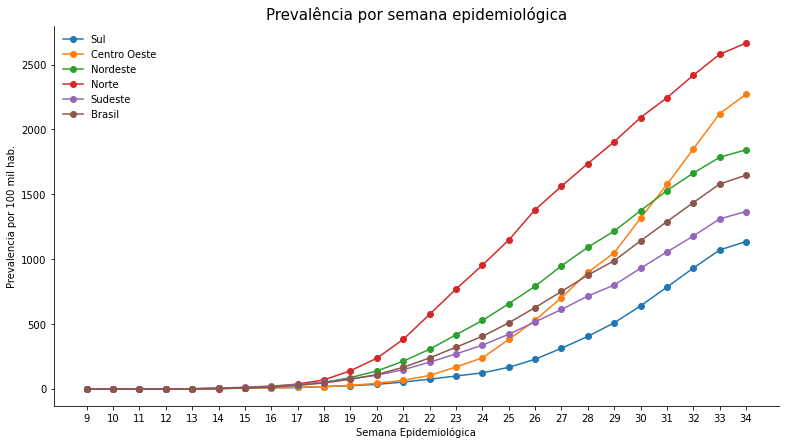

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(13,7))

plt.plot(df_reg.T[['Sul', 'centro_oeste', 'nordeste', 'norte', 'sudeste', 'Brasil']],'-o')
plt.title('Prevalência por semana epidemiológica',fontsize=15)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.ylabel('Prevalencia por 100 mil hab.')
plt.xlabel('Semana Epidemiológica')

plt.xticks(list(range(26)),list(range(9,35)))
plt.legend(['Sul', 'Centro Oeste', 'Nordeste', 'Norte', 'Sudeste', 'Brasil'], frameon=False)
fig = plt.gcf()
fig.savefig('Prevalencia_CO.svg', format='svg')

plt.show()


# 3 - Mapas
##### Plotar Mapas de cada Semana Epidemiológica de forma a ver a Evolução Temporal do Indicador Epidemiológico do grupo